<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_34_PRAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression , LinearRegression
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, f1_score, accuracy_score, mean_squared_error


from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/vlbw.csv')

##### 1.1
뇌출혈 관련 변수 3개 (pvh, ivh, ipe)의 변수들 간의 연관성을 확인하려한다.
변수를 두개씩 조합하여 교차표를 만들고 적절한 방법을 통해 연관성을 판단하라

In [3]:
from itertools import combinations

lst = ['pvh','ivh','ipe']

pairs = list(combinations(lst, 2))


res = []
for v1, v2 in pairs :
  tab = pd.crosstab(df[v1], df[v2])
  print(tab)
  stat, p_val, _ , _ = chi2_contingency(tab)
  decision = '독립이 아니다' if p_val < 0.05 else '독립이다'
  res.append([v1, v2, p_val, decision])
print(pd.DataFrame(res))

ivh       absent  definite  possible
pvh                                 
absent       321        34         5
definite      81        39         5
possible      39         2         0
ipe       absent  definite  possible
pvh                                 
absent       330        20        10
definite     105        15         4
possible      35         3         3
ipe       absent  definite  possible
ivh                                 
absent       412        16        14
definite      50        21         3
possible       9         1         0
     0    1             2        3
0  pvh  ivh  4.049839e-09  독립이 아니다
1  pvh  ipe  7.848100e-02     독립이다
2  ivh  ipe  4.632591e-12  독립이 아니다



Bleed
-pvh,ivh,ipe가 모두 absent 값이라면 0, 셋 중 하나라도 positive or definite이면 1, 그 외 na

Ind
-pvh,ivh,ipe를 제외한 모든 컬럼이 결측치가 없으면 0, bleed가 결측이면 1, 나머지는 2

In [4]:
# Bleed

def bleed(x) :
  if x['pvh'] == 'absent' and x['ivh'] == 'absent' and x['ipe'] == 'absent' :
    return 0

  elif x[['pvh','ivh','ipe']].isin(['positive','definite']).any() :
    return 1

  else :
    return np.nan

# df.apply(bleed, axis = 1).value_counts()

df['bleed'] =    np.where(
        (df[['pvh','ivh','ipe']] == 'absent').all(axis  = 1), 0 ,
        np.where(
            (df[['pvh','ivh','ipe']].isin(['positive','definite'])).any(axis = 1) , 1, np.nan
        )
    )
df['bleed'].value_counts()


def change_bleed(x) :
  if all(val == 'absent' for val in [x['pvh'], x['ivh'], x['ipe']]) :
    return 0
  elif any(val in ['positive','definite'] for val in [x['pvh'], x['ivh'], x['ipe']]) :
    return 1
  else :
    np.nan

In [5]:
#Ind -pvh,ivh,ipe를 제외한 모든 컬럼이 결측치가 없으면 0, bleed가 결측이면 1, 나머지는 2

def ind(x) :
  if x.drop(['pvh','ivh','ipe']).isna().sum() == 0 :
    return 0

  elif pd.isna(x['bleed']) :
    return 1

  else :
    return 2

#df.apply(ind ,axis = 1).value_counts()

df['ind'] = np.where(
                      (df.drop(columns = ['pvh','ivh','ipe']).isna().sum(axis = 1) == 0) , 0 ,
                      np.where(
                          pd.isna(df['bleed']) , 1, 2
                      ))


df['ind'].value_counts()

,count
ind,
0,350
1,193
2,128


#### pvh,ivh,ipe 컬럼을 제외하고 나머지 컬럼들에 대한 전처리를 진행하라

- 결측치 처리
- 범주형 변수 변환
- dead를 종속변수로 가정하고 모델링에 적합하지 않다 생각하는 변수 제거 등

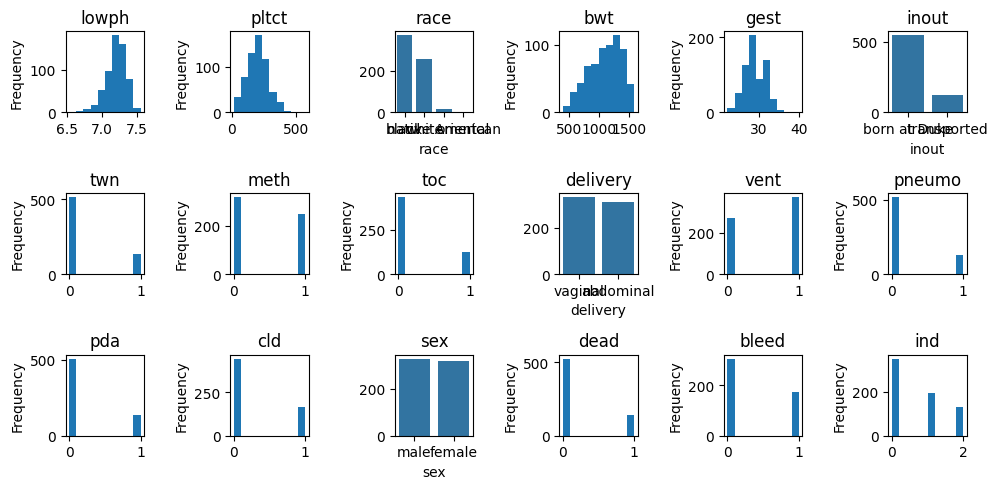

In [6]:
df2 = df.copy()
df2 = df2.drop(columns = ['pvh','ivh','ipe'], axis =1)

# 결측을 위한 EDA
fig, axes = plt.subplots(3,6, figsize = (10, 5))

for axes, col in zip(axes.flatten(), df2.columns) :
  if df2[col].dtypes == 'object' :
    target = df2[col].value_counts()
    sns.barplot(x = target.index, y = target.values , ax = axes)

  else :
    df2[col].plot(kind = 'hist', ax = axes)

  axes.set_title(col)

plt.tight_layout()
plt.show()

In [7]:
# 결측치 처리

# 1. 연속형인 경우, median()
# 2. 범주형인 경우 - Unknown 처리
# 3. 이진 변수 - Mode 처리

df22 = df2.copy()

for col in df22.columns :
  if df22[col].dtypes == 'object' :
    df22[col] = df22[col].fillna('Unknown')
  elif df22[col].nunique() == 2 :
    df22[col] = df22[col].fillna(df22[col].mode()[0])

  else :
    df22[col] = df22[col].fillna(df22[col].median())

In [8]:
# 범주형 변수 변환
# get_dummies

dum_df = pd.DataFrame()

for col in df22.columns :
  if df22[col].dtype == 'object' :
    dummies = pd.get_dummies(df22[col] , dtype = int, prefix = col , drop_first= True)
    for d in dummies.columns :
      dum_df[d] = dummies[d]

  else :
    dum_df[col] = df22[col]


dum_df.head(3)

,lowph,pltct,race_black,race_native American,race_oriental,race_white,bwt,gest,inout_born at Duke,inout_transported,...,delivery_vaginal,vent,pneumo,pda,cld,sex_female,sex_male,dead,bleed,ind
0,7.209999,100.0,0,0,0,1,1250.0,35.0,1,0,...,0,0.0,0.0,0.0,0.0,1,0,0,0.0,1
1,7.250000,244.0,0,0,0,1,1370.0,32.0,1,0,...,0,0.0,0.0,0.0,0.0,1,0,0,0.0,1
2,7.059998,114.0,1,0,0,0,620.0,23.0,1,0,...,1,1.0,0.0,0.0,0.0,1,0,1,0.0,1


In [9]:
# dead를 종속변수로 가정하고 모델링에 적합하지 않다 생각하는 변수 제거 등
# 1. 다중 공선성 확인하기 - 독립 변수들끼리의 선형 상관성을 보는 것 dead는 제외

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()


X = dum_df.drop(columns = ['dead'], axis = 1)

# 컬럼
vif['columns'] = X.columns

vif['vif'] = [variance_inflation_factor(X.values, i ) for i in range(X.shape[1])]
print(vif)

# 다중공선성으로 제거할 리스트 뽑기
vif_cols = vif[vif['vif'] > 10]['columns'].to_list()

removed_vif = dum_df.drop(columns = vif_cols)
removed_vif

                 columns         vif
0                  lowph  483.115089
1                  pltct   10.120759
2             race_black   66.337259
3   race_native American    3.909224
4          race_oriental    1.791000
5             race_white   46.318065
6                    bwt   47.628793
7                   gest  376.081242
8     inout_born at Duke  182.407142
9      inout_transported   40.527673
10                   twn    1.405682
11                  meth    2.137540
12                   toc    1.502604
13    delivery_abdominal   70.112133
14      delivery_vaginal   74.613103
15                  vent    4.146572
16                pneumo    1.550741
17                   pda    1.657071
18                   cld    1.982075
19            sex_female  105.657194
20              sex_male  109.213486
21                 bleed    1.484333
22                   ind    2.237723


,race_native American,race_oriental,twn,meth,toc,vent,pneumo,pda,cld,dead,bleed,ind
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
2,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0.0,1
3,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
4,0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
666,0,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0,1.0,0
667,0,0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0.0,0
668,0,0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0.0,2
669,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0,2


In [10]:
# 2. 통계 검정
from scipy import stats
target_col = removed_vif.columns.difference(['dead'])

res = []
for col in target_col :
  if removed_vif[col].nunique() == 2 :
    tab = pd.crosstab(removed_vif[col] , removed_vif['dead'])
    stat, p_val, _,  _ = chi2_contingency(tab)
    decision = 'dead와 유의하다' if p_val < 0.05 else 'dead와 유의하지 않다'

  else :
    t = removed_vif.groupby(['dead'])[col].apply(list)
    stat, p_val = stats.ttest_ind(t[0], t[1])
    decision = 'dead간 차이가 있다' if p_val < 0.05 else 'dead간 차이가 없다'

  res.append([col, p_val, decision])



result = pd.DataFrame(res, columns = ['col','p_value','decision'])

print(result)

# 유의하지 않은 컬럼 선택
remove_col = result[result['p_value'] > 0.05]['col'].to_list()
print(remove_col)

# 제외한 데이터 프레임 - new_df
new_df = removed_vif.drop(columns = remove_col)


                     col       p_value       decision
0                  bleed  3.535601e-04     dead와 유의하다
1                    cld  1.553220e-01  dead와 유의하지 않다
2                    ind  5.301124e-10   dead간 차이가 있다
3                   meth  4.578544e-06     dead와 유의하다
4                    pda  1.227179e-03     dead와 유의하다
5                 pneumo  3.871312e-19     dead와 유의하다
6   race_native American  5.649802e-01  dead와 유의하지 않다
7          race_oriental  1.000000e+00  dead와 유의하지 않다
8                    toc  2.537098e-01  dead와 유의하지 않다
9                    twn  4.154691e-01  dead와 유의하지 않다
10                  vent  1.733721e-24     dead와 유의하다
['cld', 'race_native American', 'race_oriental', 'toc', 'twn']


In [11]:
new_df

,meth,vent,pneumo,pda,dead,bleed,ind
0,0.0,0.0,0.0,0.0,0,0.0,1
1,1.0,0.0,0.0,0.0,0,0.0,1
2,0.0,1.0,0.0,0.0,1,0.0,1
3,1.0,0.0,0.0,0.0,0,0.0,1
4,0.0,1.0,1.0,0.0,1,1.0,0
...,...,...,...,...,...,...,...
666,0.0,1.0,1.0,0.0,0,1.0,0
667,0.0,1.0,0.0,1.0,0,0.0,0
668,0.0,1.0,0.0,1.0,0,0.0,2
669,0.0,1.0,0.0,1.0,1,0.0,2


### 1-5 bleed를 예측하기 위한 단일 알고리즘 모델과 앙상블 모델을 비교 분석 서술하라.

- dead,pvh,ivh,ipe,Ind 컬럼은 제외
- 종속변수는 Bleed, Bleed가 결측치인 경우 해당 행 제외
- Ind값이 2인 데이터는 학습에 사용하고, Ind가 0인 데이터로 테스트를 진행하라
- 적절한 평가지표를 선택하라
- 변수중요도를 구해서 중요한 2개변수는 따로 출력을 한다.

In [12]:
# dead,pvh,ivh,ipe,Ind 컬럼은 제외 - 앞에서 제외한 df2
df2

# 종속변수는 Bleed, Bleed가 결측치인 경우 해당 행 제외
df5 =df2.loc[pd.isna(df2['bleed']) == False].reset_index(drop = True)

# 전처리 수행
# 1) 결측 처리
for col in df5.columns :
  if df5[col].dtypes == 'object' :
    df5[col] = df5[col].fillna('Unknown')
  elif df5[col].nunique() == 2 :
    df5[col] = df5[col].fillna(df5[col].mode()[0])

  else :
    df5[col] = df5[col].fillna(df5[col].median())

y = df5[['ind','bleed']]

# 전처리 수행
# 범주형 - 더미화, 연속형 - 스케일링
df6 = pd.DataFrame()

for col in df5.columns.difference(['bleed','ind']) :
  if df5[col].dtype == 'object' :
    dummies = pd.get_dummies(df5[col] , dtype = int, prefix = col , drop_first= True)
    for d in dummies.columns :
      df6[d] = dummies[d]

  else :
    df6[col] =  StandardScaler().fit_transform(df5[[col]]).flatten()


df6.head(3)

,bwt,cld,dead,delivery_abdominal,delivery_vaginal,gest,inout_born at Duke,inout_transported,lowph,meth,...,pneumo,race_black,race_native American,race_oriental,race_white,sex_female,sex_male,toc,twn,vent
0,-0.589599,-0.650092,1.981877,1,0,-0.308363,1,0,-1.664394,-0.753136,...,1.981877,1,0,0,0,1,0,-0.501307,-0.511091,0.722698
1,-0.530877,-0.650092,-0.504572,1,0,-0.308363,1,0,-0.003782,1.327782,...,-0.504572,0,0,0,1,1,0,-0.501307,-0.511091,0.722698
2,-1.470435,-0.650092,1.981877,0,0,-1.980957,1,0,0.071684,-0.753136,...,-0.504572,0,0,0,0,0,0,-0.501307,-0.511091,0.722698


In [13]:
# 종속변수 bleed와 병합
bleed_df = pd.concat([df6, y] , axis = 1)
bleed_df.head(3)

,bwt,cld,dead,delivery_abdominal,delivery_vaginal,gest,inout_born at Duke,inout_transported,lowph,meth,...,race_native American,race_oriental,race_white,sex_female,sex_male,toc,twn,vent,ind,bleed
0,-0.589599,-0.650092,1.981877,1,0,-0.308363,1,0,-1.664394,-0.753136,...,0,0,0,1,0,-0.501307,-0.511091,0.722698,0,1.0
1,-0.530877,-0.650092,-0.504572,1,0,-0.308363,1,0,-0.003782,1.327782,...,0,0,1,1,0,-0.501307,-0.511091,0.722698,2,0.0
2,-1.470435,-0.650092,1.981877,0,0,-1.980957,1,0,0.071684,-0.753136,...,0,0,0,0,0,-0.501307,-0.511091,0.722698,2,0.0


In [14]:
# Ind값이 2인 데이터는 학습에 사용하고, Ind가 0인 데이터로 테스트를 진행
train_set = bleed_df[bleed_df['ind'] == 2].reset_index(drop = True)
x_train  = train_set.drop(columns = ['bleed' ,'ind'] , axis = 1)
y_train = train_set['bleed']


test_set = bleed_df[bleed_df['ind'] == 0].reset_index(drop = True)
x_test  = test_set.drop(columns = ['bleed' ,'ind'] , axis = 1)
y_test = test_set['bleed']


# 적절한 평가지표를 선택 - Accuracy Score와 F1_score로 평가
# 모델은 랜덤 포레스트와 Logistic 선택


def model_eval(model, name) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  accu = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  return accu, f1


score = []
model_lst = []
for name, model in [['LR', LogisticRegression()] , ['RF', RandomForestClassifier(random_state = 42)]] :
  accu, f1 = model_eval(model, name)
  score.append([name, accu, f1])
  model_lst.append([name, model])


print(pd.DataFrame(score , columns = ['Model_Name','Accuracy_Score','F1_score']))

  Model_Name  Accuracy_Score  F1_score
0         LR        0.582857  0.420635
1         RF        0.611429  0.433333


LR top-2 ['inout_transported', 'race_native American']
RF top--2 ['lowph', 'bwt']


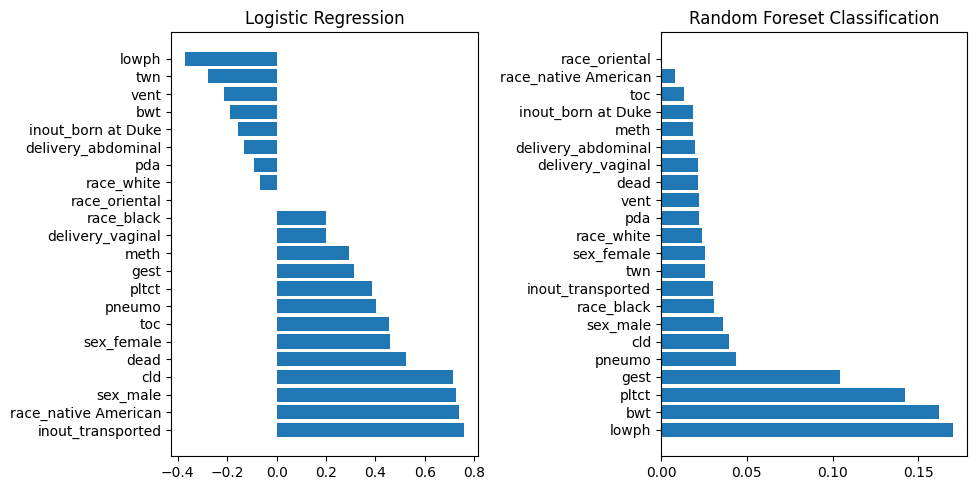

In [15]:

#변수중요도를 구해서 중요한 2개변수는 따로 출력
fig, axes = plt.subplots(1,2 , figsize = (10, 5))

for name, model in model_lst :
  if name == 'LR' :
    imp = model.coef_[0]
    feature = model.feature_names_in_
    lr_imp = pd.Series(imp, index = feature).sort_values(ascending=  False)

    axes[0].barh(lr_imp.index, lr_imp.values)
    axes[0].set_title('Logistic Regression')

  elif name == 'RF' :
    rf_imp = model.feature_importances_
    rf_feature = model.feature_names_in_
    rf_imp = pd.Series(rf_imp, index = rf_feature).sort_values(ascending=  False)

    axes[1].barh(rf_imp.index, rf_imp.values)
    axes[1].set_title('Random Foreset Classification')

    print("LR top-2" , lr_imp.head(2).index.to_list())
    print('RF top--2' , rf_imp.head(2).index.to_list())

plt.tight_layout()
plt.show()

### 1-6 dead 컬럼을 예측하기 위한 기계학습 모델

- pvh,ivh,ipe,Ind 제외 / Bleed 포함
- Ind 값이 1,2인 경우 학습데이터 / 0인 경우 테스트데이터
- 모델링 및 평가 방식은 1-5와 동일하게 진행

In [16]:
# dead,pvh,ivh,ipe,Ind 컬럼은 제외 - 앞에서 제외한 df2
df2

dead_df = df2.copy()
# 전처리 수행
# 1) 결측 처리
for col in dead_df.columns :
  if dead_df[col].dtypes == 'object' :
    dead_df[col] = dead_df[col].fillna('Unknown')
  elif df5[col].nunique() == 2 :
    dead_df[col] = dead_df[col].fillna(dead_df[col].mode()[0])

  else :
    dead_df[col] = dead_df[col].fillna(dead_df[col].median())

y = dead_df[['ind','dead']]

# 전처리 수행
# 범주형 - 더미화, 연속형 - 스케일링
dead_clean = pd.DataFrame()

for col in dead_df.columns.difference(['dead','ind']) :
  if dead_df[col].dtype == 'object' :
    dummies = pd.get_dummies(dead_df[col] , dtype = int, prefix = col , drop_first= True)
    for d in dummies.columns :
      dead_clean[d] = dummies[d]

  else :
    dead_clean[col] =  StandardScaler().fit_transform(dead_df[[col]]).flatten()


dead_clean.head(3)

# 종속변수 dead와 병합
dead_final = pd.concat([dead_clean, y] , axis = 1)
dead_final.head(3)

,bleed,bwt,cld,delivery_abdominal,delivery_vaginal,gest,inout_born at Duke,inout_transported,lowph,meth,...,race_native American,race_oriental,race_white,sex_female,sex_male,toc,twn,vent,ind,dead
0,-0.587103,0.589626,-0.56645,1,0,2.412218,1,0,0.053894,-0.763248,...,0,0,1,1,0,-0.483173,-0.501862,-1.222466,1,0
1,-0.587103,1.043081,-0.56645,1,0,1.230616,1,0,0.347279,1.310191,...,0,0,1,1,0,-0.483173,-0.501862,-1.222466,1,0
2,-0.587103,-1.791011,-0.56645,0,1,-2.314192,1,0,-1.046281,-0.763248,...,0,0,0,1,0,2.069653,-0.501862,0.818018,1,1


  Model_Name  Accuracy_Score  F1_score
0         LR        0.831429  0.486957
1         RF        0.874286  0.488372
LR top-2 ['vent', 'pneumo']
RF top--2 ['gest', 'bwt']


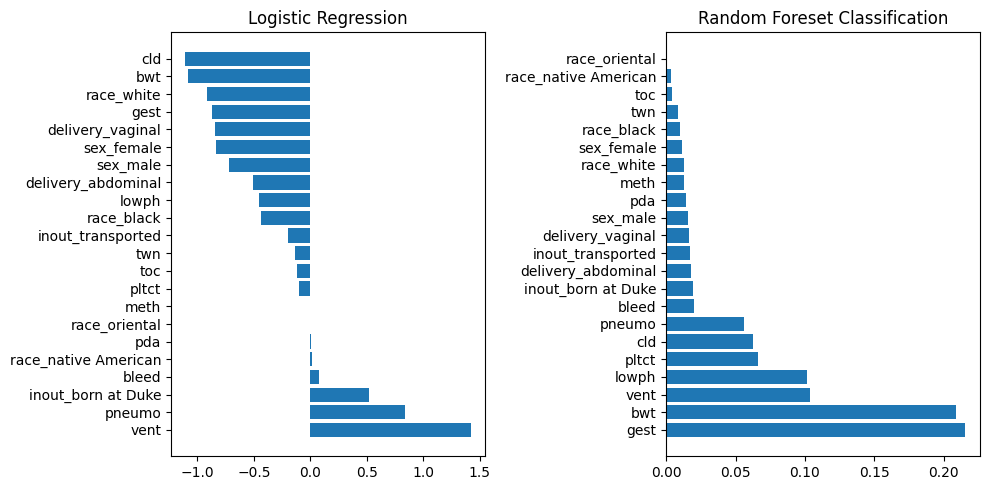

In [17]:
# Ind값이 2인 데이터는 학습에 사용하고, Ind가 0인 데이터로 테스트를 진행
train_set = dead_final[dead_final['ind'].isin([1,2])].reset_index(drop = True)
x_train  = train_set.drop(columns = ['dead' ,'ind'] , axis = 1)
y_train = train_set['dead']


test_set = dead_final[dead_final['ind'] == 0].reset_index(drop = True)
x_test  = test_set.drop(columns = ['dead' ,'ind'] , axis = 1)
y_test = test_set['dead']


# 적절한 평가지표를 선택 - Accuracy Score와 F1_score로 평가
# 모델은 랜덤 포레스트와 Logistic 선택


def model_eval(model, name) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  accu = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  return accu, f1


score = []
model_lst = []
for name, model in [['LR', LogisticRegression()] , ['RF', RandomForestClassifier(random_state = 42)]] :
  accu, f1 = model_eval(model, name)
  score.append([name, accu, f1])
  model_lst.append([name, model])


print(pd.DataFrame(score , columns = ['Model_Name','Accuracy_Score','F1_score']))


#변수중요도를 구해서 중요한 2개변수는 따로 출력
fig, axes = plt.subplots(1,2 , figsize = (10, 5))

for name, model in model_lst :
  if name == 'LR' :
    imp = model.coef_[0]
    feature = model.feature_names_in_
    lr_imp = pd.Series(imp, index = feature).sort_values(ascending=  False)

    axes[0].barh(lr_imp.index, lr_imp.values)
    axes[0].set_title('Logistic Regression')

  elif name == 'RF' :
    rf_imp = model.feature_importances_
    rf_feature = model.feature_names_in_
    rf_imp = pd.Series(rf_imp, index = rf_feature).sort_values(ascending=  False)

    axes[1].barh(rf_imp.index, rf_imp.values)
    axes[1].set_title('Random Foreset Classification')

    print("LR top-2" , lr_imp.head(2).index.to_list())
    print('RF top--2' , rf_imp.head(2).index.to_list())

plt.tight_layout()
plt.show()

#### Machine Learning 2
1. 전력량데이터 (m2_source.csv)
- 21~23년의 A지역에서의 시간대별 태양열, 풍력 발전기에 의한 발전량
2. 기상데이터 (m2_weather.csv)
- 21~23년의 A지역에서의 시간대별 기상정보에 대한 데이터

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/m2_source.csv')
df.head(3)

,일자,자원,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
0,2021-01-01,태양광,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.07,...,22.62,15.22,8.02,1.89,0.10,0.81,0.11,0.01,0.01,0.01
1,2021-01-01,풍력,119.64,105.18,106.19,76.71,65.16,79.13,47.67,39.37,...,29.19,27.11,23.78,19.02,36.62,24.00,19.66,14.78,23.45,21.14
2,2021-01-02,태양광,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,...,109.39,76.44,30.46,6.49,4.43,3.87,1.45,0.84,0.13,0.01


In [36]:
df['일자'] = pd.to_datetime(df['일자'])

In [37]:
melt_df = df.melt(id_vars = ['일자','자원'] ,
          var_name= 'hour',
          value_name = '전력량')
melt_df

,일자,자원,hour,전력량
0,2021-01-01,태양광,hour_1,0.00
1,2021-01-01,풍력,hour_1,119.64
2,2021-01-02,태양광,hour_1,0.00
3,2021-01-02,풍력,hour_1,36.33
4,2021-01-03,태양광,hour_1,0.04
...,...,...,...,...
52555,2023-12-29,풍력,hour_24,11.44
52556,2023-12-30,태양광,hour_24,0.00
52557,2023-12-30,풍력,hour_24,64.13
52558,2023-12-31,태양광,hour_24,0.00


In [38]:
pivot_df = melt_df.pivot_table(index = ['일자' ,'hour'] ,
                                  columns = '자원',
                                  values = '전력량').reset_index()

pivot_df['hour'] = pivot_df['hour'].str.split('_').str[1].str.zfill(2)
pivot_df

자원,일자,hour,태양광,풍력
0,2021-01-01,01,0.00,119.64
1,2021-01-01,10,16.81,31.86
2,2021-01-01,11,44.53,30.40
3,2021-01-01,12,52.61,15.22
4,2021-01-01,13,39.06,18.47
...,...,...,...,...
26274,2023-12-31,05,0.00,150.62
26275,2023-12-31,06,0.00,196.13
26276,2023-12-31,07,0.00,217.37
26277,2023-12-31,08,0.17,218.39


In [39]:
# hour가 24시까지 있어서 전환이 안됨 hour를 숫자로 바꾸고 -1을 빼면 처리가 됨
pivot_df['hour'] = pivot_df['hour'].astype(int)
pivot_df['date'] = pivot_df['일자'] + pd.to_timedelta(pivot_df['hour'] - 1, unit='h')
pivot_df = pivot_df[['date','hour','태양광','풍력']]

In [40]:
pivot_df = pivot_df.sort_values('date')

In [41]:
# 결측치가 존재하는 시간대의 동일 일자, 동일 자원 데이터의 직전 값과 다음 값의 평균으로 대치한다.
# 연속된 시간대의 결측치가 있다면 결측치가 아닌 이전 시간대의 값과 이후 시간대의 값의 평균으로 모든 연속 시간대 결측치를 대치한다.
# 맨앞이나 맨뒤에 결측치가 존재한다면 직전, 직후 시간대 값으로 대치한다.


pivot_df['day'] = pd.to_datetime(pivot_df['date']).dt.normalize()
pivot_df['hour'] = pivot_df['date'].dt.hour


col = ['태양광','풍력']
# 동일 일자에 직전값과, 다음값
# 직전값 - ffill
prev = pivot_df.groupby(['day'])[col].transform(lambda x : x.ffill())

# 다음값 - bfill
next = pivot_df.groupby(['day'])[col].transform(lambda x : x.bfill())

# 중간/연속
avg = (prev + next) / 2

# notna() >> True/False 마스크 -> True면 원래 값, False 면 다른값 교체
filled  = pivot_df[col].where(pivot_df[col].notna(), avg)

# 3) 맨앞/맨뒤 남은 NaN → 인접값으로 채움
filled = filled.fillna(prev).fillna(next)

# 결과 반영
pivot_df[col] = filled
pivot_df = pivot_df.drop(columns= 'day')


# avg를 구해서, 중간에 np.nan이 1개 있던 연속으로 2개가 있던 평균 값으로 대체 되기 때문에 같은 로직
# fillna().fillna()를 두 번쓰면 순서대로 첫 행부터 마지막 행에 대한 결측이 처리가 됨
# 맨 앞과 맨 뒤는, 평균을 구할 수가 없음으로 순차적으로 NA를 어떻게 처리하는지에 대한 코드를 알고 있어야함


# A.combine_first(B)
# - A에 결과가 있으면 A그대로, A가 nan이면 B로 채움
# A.combine_first(B).combine_first(C)
# df[col].combine_first(avg_val) \
#       .combine_first(pre) \
#       .combine_first(next)

In [42]:
pivot_df.isna().sum()

,0
자원,
date,0
hour,0
태양광,0
풍력,0


In [43]:
pivot_df.head(3)

자원,date,hour,태양광,풍력
0,2021-01-01 00:00:00,0,0.0,119.64
11,2021-01-01 01:00:00,1,0.0,105.18
17,2021-01-01 02:00:00,2,0.0,106.19


#### 결측치를 제거한 전력량 데이터에 대해 총전력량(태양광 + 풍력 발전량의 합)을 구한다.
- 동일 일자 동일 시간대에 대해 태양광과 풍력의 합을 구한다. 하나의 일자는 하나의 행에 시간대별 총전력량을 표현해야한다.
- 특정일자에 태양광 또는 풍력이 하나만 있는 경우에는 해당 자원의 전력량을 2배로 한다.

In [44]:
pivot_df['총전력량'] = pivot_df['태양광'] + pivot_df['풍력']


In [45]:
pivot_df['총전력량']  =  np.where(
                                ((pivot_df['태양광'] == 0) & (pivot_df['풍력'] > 0)) |
                                ((pivot_df['풍력'] == 0) & (pivot_df['태양광'] > 0))  ,
                                pivot_df['총전력량'] * 2,
                                pivot_df['총전력량']
                              )

In [82]:
pivot_df.head(3)

final_df = pivot_df.loc[~pivot_df['date'].dt.month.isin([1,2])].reset_index(drop =True)
final_df.columns.name = ''
final_df.head()

,date,hour,태양광,풍력,총전력량
0,2021-03-01 00:00:00,0,0.18,99.41,99.59
1,2021-03-01 01:00:00,1,0.01,112.44,112.45
2,2021-03-01 02:00:00,2,0.00,123.76,247.52
3,2021-03-01 03:00:00,3,0.00,126.22,252.44
4,2021-03-01 04:00:00,4,0.05,136.00,136.05


In [125]:
w = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/m2_weather.csv')
w.head(3)

,일시,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도
0,2021_01_01@0,4.5,NaN,6.1,53.0,NaN,NaN,NaN,9.0,2.2
1,2021_01_01@1,4.3,NaN,5.6,58.0,NaN,NaN,NaN,9.0,2.4
2,2021_01_01@2,4.2,NaN,5.5,54.0,NaN,NaN,NaN,10.0,2.3


#### 기상데이터의 결측치를 처리한다
- 강수량, 일조, 일사, 적설은 0으로 채운다.
- 풍속, 습도는 직전값으로 전운량과 지면온도는 전체 평균값으로 대치한다.

In [126]:
w['일시'] = pd.to_datetime(w['일시'].str.replace('_','-').str.split('@').str[0] +
                    ' ' +
                    w['일시'].str.split('@').str[1].str.zfill(2) ,
                    format = '%Y-%m-%d %H')


In [127]:
print(w['일시'].min(), w['일시'].max())

2021-01-01 00:00:00 2023-12-31 23:00:00


In [128]:
ww = w.copy()
for col in ww.columns :
  if col in[ '강수량', '일조', '일사', '적설','기온'] :
    ww[col] = ww[col].fillna(0)

  elif col in ['풍속','습도'] :
    ww[col] = ww[col].fillna(method = 'ffill')

  elif col in ['전운량','지면온도'] :
    ww[col] = ww[col].fillna(ww[col].mean())

  else :
    ww[col]

#ww.isna().sum()


/tmp/ipython-input-2898344328.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ww[col] = ww[col].fillna(method = 'ffill')


In [129]:
filter_w = ww.loc[~ww['일시'].dt.month.isin([1,2])].reset_index(drop =True)

In [131]:
m_df = pd.merge(final_df, filter_w, how = 'left', left_on = 'date', right_on = '일시').drop(columns = ['hour','일시','태양광','풍력'])
m_df.head(4)

,date,총전력량,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도
0,2021-03-01 00:00:00,99.59,16.6,0.0,4.6,73.0,0.0,0.0,0.0,6.0,12.3
1,2021-03-01 01:00:00,112.45,17.6,0.0,5.1,68.0,0.0,0.0,0.0,10.0,12.8
2,2021-03-01 02:00:00,247.52,17.6,0.0,4.7,67.0,0.0,0.0,0.0,9.0,12.6
3,2021-03-01 03:00:00,252.44,17.9,0.0,4.6,66.0,0.0,0.0,0.0,9.0,12.5


파생변수를 생성한다.
변수명 season
3-5월 0, 6-8월 1, 9-10월 2, 11-12월 3

In [132]:
m_df['month']= m_df['date'].dt.month

def season(x) :
  month = x['month']

  if month in [3,4,5] :
    return 0

  elif month in [6,7,8] :
    return 1

  elif month in [9,10] :
    return 2

  else :
    return 3

m_df['season'] = m_df.apply(season, axis = 1)
m_df = m_df.drop('month', axis = 1)
m_df.head()

,date,총전력량,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도,season
0,2021-03-01 00:00:00,99.59,16.6,0.0,4.6,73.0,0.0,0.0,0.0,6.0,12.3,0
1,2021-03-01 01:00:00,112.45,17.6,0.0,5.1,68.0,0.0,0.0,0.0,10.0,12.8,0
2,2021-03-01 02:00:00,247.52,17.6,0.0,4.7,67.0,0.0,0.0,0.0,9.0,12.6,0
3,2021-03-01 03:00:00,252.44,17.9,0.0,4.6,66.0,0.0,0.0,0.0,9.0,12.5,0
4,2021-03-01 04:00:00,136.05,18.8,0.0,6.2,63.0,0.0,0.0,0.0,9.0,12.5,0


2-2
전처리 완료된 데이터의 기술 통계량 및 EDA를 실시하라 (시각화 포함)

In [133]:
m_df[m_df.columns.difference(['date'])].describe()

,season,강수량,기온,습도,일사,일조,적설,전운량,지면온도,총전력량,풍속
count,22032.000000,22032.000000,22032.000000,22032.000000,22032.000000,22032.000000,22032.000000,22032.000000,22032.000000,22032.000000,22032.000000
mean,1.297386,0.171977,19.341095,71.318396,0.621419,0.240468,0.019812,6.055961,21.647453,113.854111,3.216989
std,1.099546,1.318879,7.313187,14.498993,0.966066,0.389433,0.344878,3.583055,10.158836,91.820178,1.821636
min,0.000000,0.000000,-0.300000,14.000000,0.000000,0.000000,0.000000,0.000000,1.100000,0.000000,0.000000
25%,0.000000,0.000000,13.800000,61.000000,0.000000,0.000000,0.000000,3.000000,13.800000,33.690000,1.900000
50%,1.000000,0.000000,19.600000,72.000000,0.010000,0.000000,0.000000,7.000000,22.000000,93.820000,2.900000
75%,2.000000,0.000000,25.400000,82.000000,0.980000,0.400000,0.000000,9.000000,27.900000,179.562500,4.200000
max,3.000000,74.600000,37.000000,100.000000,3.700000,1.000000,12.200000,10.000000,67.300000,484.960000,13.700000


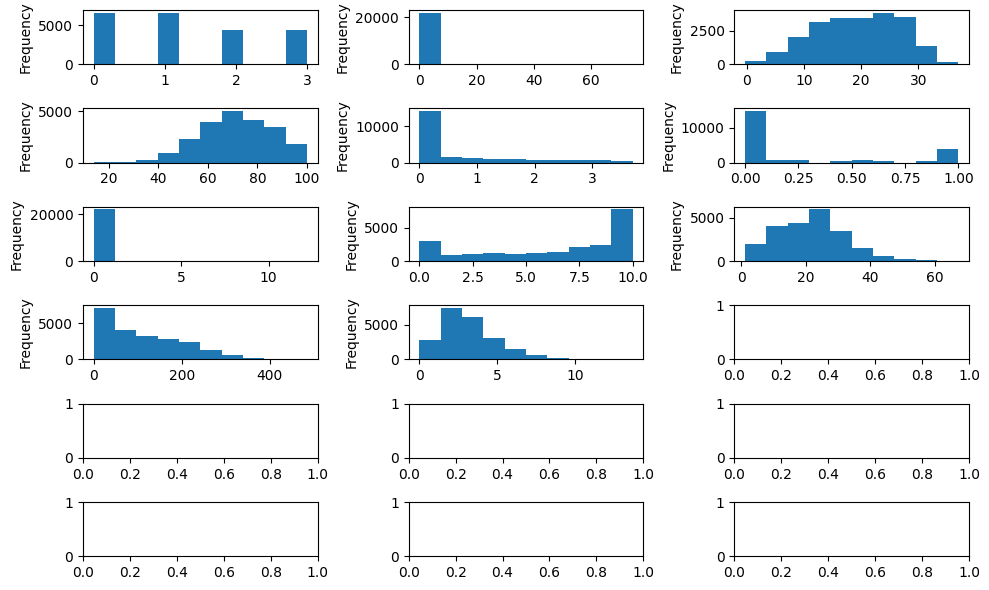

In [134]:
fig, axes = plt.subplots(6,3, figsize = (10, 6))

for axes, col in zip(axes.flatten(), m_df.columns.difference(['date'])) :
  m_df[col].plot(kind = 'hist', ax = axes)
plt.tight_layout()
plt.show()


2-3
- 총전력량을 종속변수로 하고 종속변수와 다른 연속형 변수들간의 상관관계 분석을 진행하라. 유의확률을 포함하여 분석결과를 서술하라.
- season에 따라 종속변수간의 차이가 있는지 통계적으로 확인하고 분석결과를 서술하라.

In [135]:
from scipy.stats import pearsonr

X = m_df.drop(columns = ['date','총전력량'], axis =1)
y = m_df['총전력량']

res = []
for col in X.columns :
  stat, p_val = pearsonr(X[col], y)
  decision = '유의하다' if p_val < 0.05 else '유의하지 않다'
  res.append([col, '총전력량',  p_val, decision])

print(pd.DataFrame(res, columns=['변수', 'Target', 'p_value', '판정']))

       변수 Target        p_value       판정
0      기온   총전력량   5.013235e-10     유의하다
1     강수량   총전력량   1.695315e-01  유의하지 않다
2      풍속   총전력량   0.000000e+00     유의하다
3      습도   총전력량   0.000000e+00     유의하다
4      일조   총전력량   0.000000e+00     유의하다
5      일사   총전력량   0.000000e+00     유의하다
6      적설   총전력량   2.634893e-04     유의하다
7     전운량   총전력량   2.298431e-02     유의하다
8    지면온도   총전력량  4.885627e-118     유의하다
9  season   총전력량   1.051768e-18     유의하다


In [143]:
# season에 따라 종속변수간의 차이가 있는지 통계적으로 확인하고 분석결과를 서술

res2 = []
for col in m_df.columns.difference(['season','date']) :
  g = [group[col] for name, group in m_df.groupby(['season'])]
  stat, p_val = stats.f_oneway(* g)
  decision = '그룹간 차이가 있다' if p_val < 0.05 else '그룹간 차이가 없다'
  res2.append([col, 'season',p_val , decision])

print(pd.DataFrame(res2))


# 사후분석
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for col in m_df.columns.difference(['season','date']) :
  tukey = pairwise_tukeyhsd(endog = m_df[col] ,
                            groups = m_df['season'], alpha=0.05)
  print(col)
  print(tukey)

      0       1              2           3
0   강수량  season   7.333749e-13  그룹간 차이가 있다
1    기온  season   0.000000e+00  그룹간 차이가 있다
2    습도  season   0.000000e+00  그룹간 차이가 있다
3    일사  season  8.995556e-178  그룹간 차이가 있다
4    일조  season   4.467792e-83  그룹간 차이가 있다
5    적설  season   2.033690e-63  그룹간 차이가 있다
6   전운량  season   1.414899e-60  그룹간 차이가 있다
7  지면온도  season   0.000000e+00  그룹간 차이가 있다
8  총전력량  season   4.643501e-99  그룹간 차이가 있다
9    풍속  season  3.272453e-181  그룹간 차이가 있다
강수량
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.1316    0.0  0.0728  0.1904   True
     0      2   0.0901 0.0025  0.0243   0.156   True
     0      3  -0.0402 0.3968 -0.1061  0.0257  False
     1      2  -0.0415 0.3679 -0.1073  0.0244  False
     1      3  -0.1718    0.0 -0.2377 -0.1059   True
     2      3  -0.1303    0.0 -0.2025 -0.0581   True
----------------------------------------------

2-4
아래 기준으로 회귀모델링을 진행하고 평가하라.

- 21년,22년도를 학습데이터, 23년도를 평가데이터로 사용한다.
- RMSE를 포함한 적절한 평가지표 2가지로 판단
- 일반 회귀모형 1개, 기계학습 모델 1개로 진행한다.

In [144]:
m_df.head()

,date,총전력량,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도,season
0,2021-03-01 00:00:00,99.59,16.6,0.0,4.6,73.0,0.0,0.0,0.0,6.0,12.3,0
1,2021-03-01 01:00:00,112.45,17.6,0.0,5.1,68.0,0.0,0.0,0.0,10.0,12.8,0
2,2021-03-01 02:00:00,247.52,17.6,0.0,4.7,67.0,0.0,0.0,0.0,9.0,12.6,0
3,2021-03-01 03:00:00,252.44,17.9,0.0,4.6,66.0,0.0,0.0,0.0,9.0,12.5,0
4,2021-03-01 04:00:00,136.05,18.8,0.0,6.2,63.0,0.0,0.0,0.0,9.0,12.5,0


In [149]:
train_set = m_df[m_df['date'].dt.year.isin([2021,2022])]
x_train = train_set.drop(columns = ['date','총전력량'])
y_train = train_set['총전력량']

test_set = m_df[m_df['date'].dt.year.isin([2023])]
x_test = test_set.drop(columns = ['date','총전력량'])
y_test = test_set['총전력량']



def model_eval(model, name) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  RMSE = np.sqrt(mean_squared_error(y_test, pred))
  r2 = r2_score(y_test, pred)

  return RMSE, r2


score = []
model_lst = []
for name, model in [['LR', LinearRegression()] , ['RF', RandomForestRegressor(random_state = 42)]] :
  RMSE, r2 = model_eval(model, name)
  score.append([name, RMSE, r2])
  model_lst.append([name, model])


print(pd.DataFrame(score))

    0          1         2
0  LR  75.769236  0.443580
1  RF  71.463336  0.505025


#### 통계1) MANOVA

In [150]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/student_scores.csv')

In [151]:
df.head()

,id,성별,traindition,online,mix
0,1,Male,69,74,68
1,2,Male,59,65,63
2,3,Male,60,75,63
3,4,Male,79,52,76
4,5,Male,100,77,67


In [160]:
from scipy.stats import shapiro

# 1.정규성 검토
res = []
for col in ['traindition','online','mix'] :
  for key, group in df.groupby('성별') :
    stats, p_val = shapiro(group[col])
    decision ='정규분포이다' if p_val > 0.05 else '정규분포가 아니다'
    res.append(
        {'조합' : key,
        'columns' : col,
        'p_value' : p_val,
        'deicison' : decision }
    )

print(pd.DataFrame(res))

# 2. 등분산성 검토
from scipy.stats import levene

res = []
for col in ['traindition','online','mix']:
    male = df.loc[df['성별']=='Male', col]
    female = df.loc[df['성별']=='Female', col]
    stat, p_val = levene(male, female)
    decision = '등분산성 가정 만족' if p_val > 0.05 else '등분산성 가정 위배'
    res.append({'변수': col, 'p_value': p_val, '판정': decision})

print(pd.DataFrame(res))

       조합      columns   p_value   deicison
0  Female  traindition  0.472527     정규분포이다
1    Male  traindition  0.097687     정규분포이다
2  Female       online  0.048999  정규분포가 아니다
3    Male       online  0.683060     정규분포이다
4  Female          mix  0.994322     정규분포이다
5    Male          mix  0.083163     정규분포이다
            변수   p_value          판정
0  traindition  0.208476  등분산성 가정 만족
1       online  0.729845  등분산성 가정 만족
2          mix  0.795235  등분산성 가정 만족


In [159]:
from statsmodels.multivariate.manova import MANOVA

maov = MANOVA.from_formula('traindition + online + mix ~ 성별', data=df)
print(maov.mv_test())
print('''
귀무가설(H0): 세 종속변수는 성별에 따라 차이가 없다.
대립가설(H1): 적어도 하나의 종속변수 평균은 성별에 따라 다르다.

독립변수 : 성별
p_value 가 0.9로 0.05보다 큼으로 귀무가설을 기각하지 않고, 성별에 따라 차이가 없음으로 나타난다.
''')

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0144 3.0000 36.0000 819.9393 0.0000
         Pillai's trace  0.9856 3.0000 36.0000 819.9393 0.0000
 Hotelling-Lawley trace 68.3283 3.0000 36.0000 819.9393 0.0000
    Roy's greatest root 68.3283 3.0000 36.0000 819.9393 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
             성별           Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.9858 3.0000 36.0000  0.1723 0.9144
           Pillai's trace 0.0142 3.0000 36.0000  0.1723 0.9144
   Hotellin

In [165]:
#4. 사후분석 (주효과 변수별 ANOVA + Tukey)
#MANOVA에서 성별 효과가 유의하면,
#각 종속변수별로 일원분산분석(ANOVA) 을 수행하고, 필요시 Tukey 사후검정을 합니다.
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm


for col in ['traindition','online','mix'] :
  model = ols(f'{col} ~ 성별', data = df).fit()
  anova_table = sm.stats.anova_lm(model, typ = 2)
  print(anova_table)

  # tukey 실행
  tukey =pairwise_tukeyhsd(endog = df[col],
                           groups = df['성별'],
                           alpha = 0.05)

  print(tukey)


            sum_sq    df         F    PR(>F)
성별           9.025   1.0  0.075784  0.784585
Residual  4525.350  38.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
Female   Male     0.95 0.7846 -6.036 7.936  False
-------------------------------------------------
          sum_sq    df         F    PR(>F)
성별          40.0   1.0  0.361913  0.551018
Residual  4199.9  38.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
Female   Male     -2.0 0.551 -8.7301 4.7301  False
--------------------------------------------------
            sum_sq    df        F   PR(>F)
성별          24.025   1.0  0.18912  0.66611
Residual  4827.350  38.0      NaN      NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  re

#### 통계2) 선형회귀

In [167]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/s4.csv')
df.head()

,ID,studytime,failures,schoolsup,famsup,absences,score
0,ID_1,2,0,yes,no,4,11
1,ID_2,2,0,no,yes,2,11
2,ID_3,2,0,yes,no,6,13
3,ID_4,3,0,no,yes,0,14
4,ID_5,2,0,no,yes,0,13


In [194]:
#df.isna().sum() # 결측 없음

# 전처리
clean_df = pd.DataFrame()
X = df.drop(columns = ['ID','score'], axis = 1)

for col in X.columns :
  if X[col].dtypes == 'object' :
    dummies = pd.get_dummies(X[col], dtype =int, prefix = col , drop_first= True)
    for d in dummies.columns :
      clean_df[d] = dummies[d]

  else :
    clean_df[col] =  StandardScaler().fit_transform(df[[col]]).flatten()


clean_df.head()
scaled_X = clean_df.copy()
y = df['score']

4-1 회귀모델이 유의한지 F검정에 대한 분석 및 결정계수 제시 및 해석

In [197]:
import statsmodels.api as sm
add_x = sm.add_constant(scaled_X)
model = sm.OLS(y, add_x).fit()
print(model.summary())
print('''

귀무가설 : 회귀 계수는 0이다.
대립가설 : 회귀 계수는 0이 아니다
1. F 검정 (회귀모델 유의성)
F-stastic : - 30.77,
Prob (F-statstic) : 4.23e-28 (p_value)

2. 결정계수
R-squared : 0.193 (수정 결정 계수 :0.187)

회귀모형의 유의성은 p_value가 0.05보다 큼으로 귀무가설을 채택하여 회귀 모형이
유의하다고 할 수있다. 결정계수는 score변동의 19.3%을 설명하고 있어, 모형은 유의하다
모형의 설명력을 비교적 낮다고 해석한다.
''')

# 예) schoolsup_yes 계수 → “yes인 경우, no 집단 대비 score 변화”
# 더미에서 drop_first을 선택하면
# famsup_yes의 경우, no집단 대비 yes 집단의 평균 변화량으로 해석
# 해석) schoolsup_yes인 학생은 no인 학생보다 score가 -0.74정도 낮다
# 해석) famsup_yes 학생은 no인 학생보다 0.1 높다

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     30.77
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           4.23e-28
Time:                        11:23:20   Log-Likelihood:                -1544.8
No. Observations:                 649   AIC:                             3102.
Df Residuals:                     643   BIC:                             3129.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            11.5835      0.169     68.447


4-2 잔차를 통해 회귀모델의 유의성 검정

1.7888013848475086

1. 선형성 
- 예측값과 잔차의 산점도 확인 결과 잔차가 0을 중심으로 무작위로 퍼져 있지 않는것으로 보아 
  설명변수와 종속변수 간의 완전한 선형성이 아닐 수 있다. 

2. 독립성 
- 더빈 왓슨 검정 결과 1.8으로 자기 상관이 없어, 독립성을 대체로 충족된다.

3. 등분산성 
Breusch-Pagaen 검정 결과 p_Value가 0.05 보다 낮게 나와 등분산 가정이 위배되고 있다. 

4. 정규성 
대체로 45도 직선 위에 분포하고 있으나, 양 끝 부분에서 이탈이 나오고 있으며 
shapiro 검정에서 1.4e-09로 정규성을 따르지 않는 것으로 해석될 수 있다. 



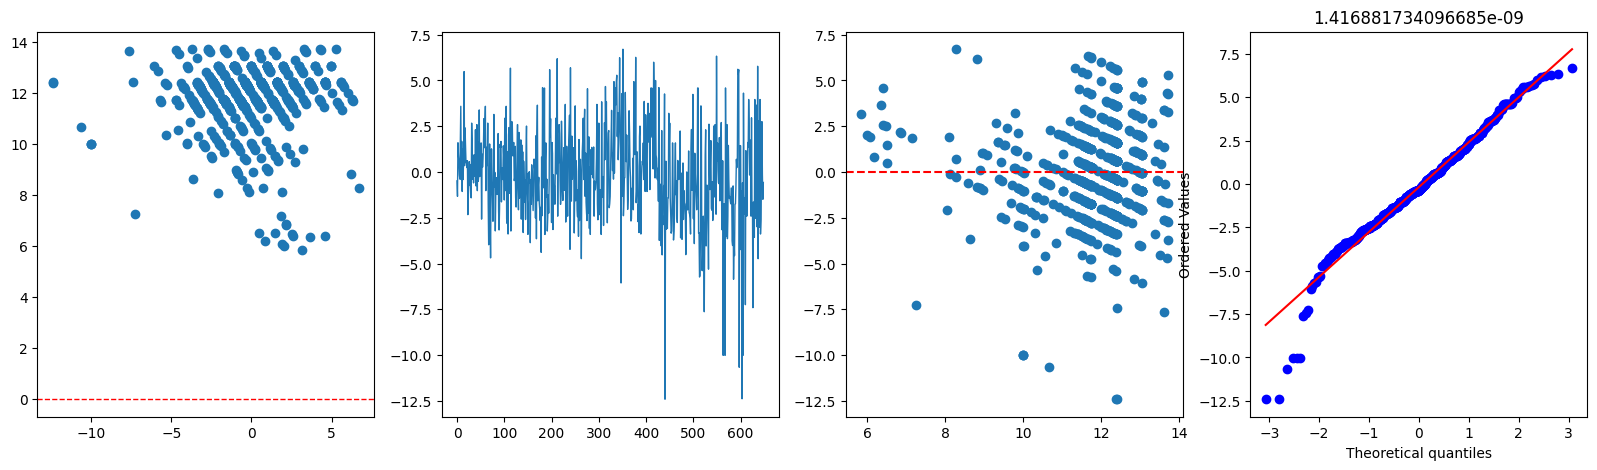

In [187]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, probplot


# 잔차
resid = model.resid
# 예측
pred =model.fittedvalues

fig, axes = plt.subplots(1,4, figsize = (20, 5))

# 1. 선형성 - 잔차 VS 예측값 : 패턴이 없어야 함
axes[0].axhline(0, color='r', linestyle='--', linewidth=1)
axes[0].scatter(resid, pred)


# 2.독립성
dw = durbin_watson(resid)
print(dw)
axes[1].plot(resid.values, linewidth=1)

# 3.등분산성
bp = het_breuschpagan(resid, model.model.exog)
p_value = bp[1]

axes[2].axhline(0, color='red', linestyle='--')
axes[2].scatter(pred, resid)

# 4. 정규성 - 잔차는 정규분포이다.  (QQ-plot)
probplot(resid, dist = 'norm', plot = axes[3])
shap = shapiro(resid).pvalue
axes[3].set_title(f'{shap}')


print('''
1. 선형성
- 예측값과 잔차의 산점도 확인 결과 잔차가 0을 중심으로 무작위로 퍼져 있지 않는것으로 보아
  설명변수와 종속변수 간의 완전한 선형성이 아닐 수 있다.

2. 독립성
- 더빈 왓슨 검정 결과 1.8으로 자기 상관이 없어, 독립성을 대체로 충족된다.

3. 등분산성
Breusch-Pagaen 검정 결과 p_Value가 0.05 보다 낮게 나와 등분산 가정이 위배되고 있다.

4. 정규성
대체로 45도 직선 위에 분포하고 있으나, 양 끝 부분에서 이탈이 나오고 있으며
shapiro 검정에서 1.4e-09로 정규성을 따르지 않는 것으로 해석될 수 있다.
''')

4-3 다중공선성이 있는지 VIF로 측정 및 확인 및 제언

In [192]:
# 독립변수만 선택
# 표준화 없이

vif_df = pd.DataFrame()
X = df.drop(columns = ['ID','score'], axis = 1)

for col in X.columns :
  if X[col].dtypes == 'object' :
    dummies = pd.get_dummies(X[col], dtype =int, prefix = col , drop_first= True)
    for d in dummies.columns :
      vif_df[d] = dummies[d]

  else :
    vif_df[col] =  X[col]

vif_df.head()

,studytime,failures,schoolsup_yes,famsup_yes,absences
0,2,0,1,0,4
1,2,0,0,1,2
2,2,0,1,0,6
3,3,0,0,1,0
4,2,0,0,1,0


In [198]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['columns'] = vif_df.columns
vif['vif'] = [variance_inflation_factor(vif_df.values , i) for i in range(vif_df.shape[1])]

print(vif)
print('''
VIF > 10 이상 심각한 다중 공선성으로 고려,
모형 설명력이 낮아 다중공선성을 점검한 결과 다중 공선성의 문제로 확인되지 않는다.
현재 사용된 설명 변수들이 종속 변수에 충분한 설명력을 제공하지 못한 것으로 해석된다.
''')

         columns       vif
0      studytime  2.584695
1       failures  1.129932
2  schoolsup_yes  1.132317
3     famsup_yes  2.437308
4       absences  1.501333

VIF > 10 이상 심각한 다중 공선성으로 고려, 
모형 설명력이 낮아 다중공선성을 점검한 결과 다중 공선성의 문제로 확인되지 않는다. 
현재 사용된 설명 변수들이 종속 변수에 충분한 설명력을 제공하지 못한 것으로 해석된다. 



4-4 회귀계수 및 검정 결과로 가장 유의한 변수 무엇인지 설명하라.

In [205]:
print("결정계수 R²:", model.rsquared)
print("수정 R²:", model.rsquared_adj)
print("F통계량:", model.fvalue)
print("F검정 p-value:", model.f_pvalue)


result = pd.DataFrame({
    'coef' : model.params ,
    'p_value' : model.pvalues
})


print(result.sort_values(by = 'p_value', ascending= True))

print('''
유의한 변수를 찾는 방법은 p_value가 가장 작은 변수로 failures , studytime
failures 가 1회 증가할 때마다 성적의 평균 1점 가량이 감소 하고 있으며, p_value가 가장
낮은 것으로 보아 가장 영향력이 크다.
studytime은 +의 형향을 주어, 공부시간이 늘어날때마다 평균 0.5의 성적이 오른다
''')

결정계수 R²: 0.19305874934253264
수정 R²: 0.18678393401860205
F통계량: 30.767240050277813
F검정 p-value: 4.229495743816003e-28
                    coef        p_value
const          11.583484  1.890997e-297
failures       -1.020001   6.097494e-21
studytime       0.540381   4.872407e-07
schoolsup_yes  -0.747920   2.787095e-02
absences       -0.189768   7.067186e-02
famsup_yes      0.105974   6.220278e-01

유의한 변수를 찾는 방법은 p_value가 가장 작은 변수로 failures , studytime 
failures 가 1회 증가할 때마다 성적의 평균 1점 가량이 감소 하고 있으며, p_value가 가장 
낮은 것으로 보아 가장 영향력이 크다.
studytime은 +의 형향을 주어, 공부시간이 늘어날때마다 평균 0.5의 성적이 오른다 

